# Исследование тарифов федерального оператора сотовой связи

**Описание проекта**

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
# Снимаем ограничение на ширину таблиы
pd.set_option('display.max_columns', None)

# Обзор данных

In [2]:
#Чтение файла в переменную
try:       # Локальный путь
    calls=pd.read_csv('calls.csv')
    internet=pd.read_csv('internet.csv')
    messages=pd.read_csv('messages.csv')
    tariffs=pd.read_csv('tariffs.csv')
    users=pd.read_csv('users.csv') 
except:        # Серверный путь
    calls=pd.read_csv('/datasets/calls.csv')
    internet=pd.read_csv('/datasets/internet.csv')
    messages=pd.read_csv('/datasets/messages.csv')
    tariffs=pd.read_csv('/datasets/tariffs.csv')
    users=pd.read_csv('/datasets/users.csv') 

**Описание данных**

Т**аблица users (информация о пользователях):**

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

**Таблица calls (информация о звонках):**

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


Изучим исходные таблицы

**calls**

In [3]:
calls.sample(5)

,id,call_date,duration,user_id
39968,1099_341,2018-09-23,5.56,1099
36207,1090_31,2018-11-28,9.64,1090
27481,1067_391,2018-08-07,6.78,1067
120168,1310_363,2018-07-05,8.78,1310
178703,1445_52,2018-12-31,14.31,1445


In [4]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


**internet**

In [6]:
internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
123998,123998,1417_32,183.58,2018-10-26,1417
97616,97616,1328_173,739.24,2018-10-25,1328
103780,103780,1352_4,1021.61,2018-06-27,1352
73230,73230,1247_268,0.00,2018-11-11,1247
146135,146135,1489_144,92.40,2018-10-06,1489


In [7]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


**messages**

In [9]:
messages.sample(5)

,id,message_date,user_id
53002,1233_187,2018-10-18,1233
7525,1030_436,2018-10-25,1030
108062,1433_669,2018-05-29,1433
115449,1471_677,2018-08-11,1471
118799,1482_361,2018-11-16,1482


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


**users**


In [11]:
users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
45,1045,48,NaN,Улан-Удэ,Джемма,Карасева,2018-01-30,smart
315,1315,49,NaN,Владивосток,Инга,Агапеева,2018-07-14,smart
434,1434,73,NaN,Москва,Карина,Субботина,2018-12-14,smart
175,1175,22,NaN,Москва,Юлий,Марков,2018-04-08,smart
52,1052,52,NaN,Санкт-Петербург,Павел,Панов,2018-07-27,smart


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


**tariffs**

In [13]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Вывод

Имеем 4 таблицы с данными и одну с информацией о тарифах
- Необходимо привести даты к типу дата тайм
- Удалить незадокументированный  столбец Unnamed: 0 в таблице интернет
- Округлить звонки в большую сторону
- Объеденить все в одну таблицу

В таблицах звонков и трафика есть нули.

Нули в звонках означают пропущенный вызов (Согласно документации)

Нули в трафике, означаюи что в данную сессию трафик не использовался.

В дальнейшей работе, мы будем суммировать звонки и трафик по месяцам, нулевые значения не помешают.

# Подготовка данных

**calls**

In [14]:
# Приведем дату в нормальный вид
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%dT%H")

In [15]:
# Округлим звонки в большую сторону, переведем значения к цеочисленному типу
calls['duration']=np.ceil(calls['duration']).astype('int')

In [16]:
calls.sample(5)

,id,call_date,duration,user_id
192543,1472_356,2018-01-18,5,1472
103053,1264_192,2018-05-04,12,1264
142011,1360_454,2018-07-19,14,1360
154119,1381_994,2018-12-25,11,1381
190196,1468_167,2018-05-28,7,1468


In [17]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int32
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB


**internet**

In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%dT%H")

In [19]:
internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
135948,135948,1456_97,345.75,2018-11-15,1456
81981,81981,1277_199,629.92,2018-04-27,1277
59068,59068,1199_27,0.00,2018-10-01,1199
136462,136462,1457_304,645.89,2018-04-13,1457
96569,96569,1325_228,38.21,2018-08-24,1325


In [20]:
# Удалим столбец Unnamed: 0, т.к его нет  документации.
internet.pop('Unnamed: 0')

0              0
1              1
2              2
3              3
4              4
           ...  
149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, Length: 149396, dtype: int64

In [21]:
internet.sample(5)

,id,mb_used,session_date,user_id
16940,1058_116,269.94,2018-10-14,1058
123277,1414_370,817.15,2018-06-07,1414
76300,1256_5,1111.50,2018-11-27,1256
35157,1123_121,0.00,2018-10-20,1123
63324,1215_230,292.47,2018-11-07,1215


In [22]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


**messages**

In [23]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%dT%H")

In [24]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


**users**

In [25]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%dT%H")
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%dT%H")

In [26]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [27]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


**tariffs**

In [28]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [29]:
# Переименуем столбец, для удобства соединения таблиц
tariffs=tariffs.rename(columns={'tariff_name':'tariff'})

In [30]:
# Объединим таблицы пользователей и тарифов
users_tar=users.merge(tariffs, on='tariff',how='left')
users_tar.groupby('tariff')['user_id'].count()

tariff
smart    351
ultra    149
Name: user_id, dtype: int64

In [31]:
users.shape

(500, 8)

In [32]:
tariffs.shape

(2, 8)

In [33]:
users_tar.shape

(500, 15)

In [34]:
users_tar.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
451,1451,58,NaT,Набережные Челны,Виктория,Завьялова,2018-08-27,smart,50,15360,500,550,200,3,3
103,1103,52,NaT,Екатеринбург,Эльвира,Лобанова,2018-12-04,smart,50,15360,500,550,200,3,3
454,1454,29,NaT,Томск,Адам,Алешин,2018-03-08,smart,50,15360,500,550,200,3,3
209,1209,27,NaT,Омск,Альбин,Сорокин,2018-06-02,smart,50,15360,500,550,200,3,3
326,1326,37,NaT,Санкт-Петербург,Леонид,Барсуков,2018-05-29,smart,50,15360,500,550,200,3,3


**Посчитаем и добавим в таблицы необходимые данные**

In [35]:
# Добавим месяца в типе дататайм
calls['month']=calls['call_date'].values.astype('datetime64[M]')
messages['month']=messages['message_date'].values.astype('datetime64[M]')
internet['month']=internet['session_date'].values.astype('datetime64[M]')

Сгрупперуем по месяцам и посчитаем необходимые значения

In [36]:
calls_gr=(
    calls
    .groupby(['user_id', 'month'])['duration']
    .agg(['count','sum'])
    .reset_index()
    .rename(columns= {'count': 'calls_count', 'sum': 'minute_sum' })
)

In [37]:
calls_gr.query('user_id==1000')

,user_id,month,calls_count,minute_sum
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466
5,1000,2018-10-01,57,350
6,1000,2018-11-01,43,338
7,1000,2018-12-01,46,333


In [38]:
messages_gr=messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_gr=messages_gr.rename(columns= {'id': 'mes_count'})

In [39]:
messages_gr.query('user_id==1000')

,user_id,month,mes_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
5,1000,2018-10-01,73
6,1000,2018-11-01,58
7,1000,2018-12-01,70


In [40]:
internet_gr=internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
# Округлим мегабыйты в большую сторону и переведем в гигабайты
internet_gr['mb_used']=np.ceil(internet_gr['mb_used']/1024).astype('int')
internet_gr=internet_gr.rename(columns= {'mb_used':'internet_gb' })

In [41]:
internet_gr.query('user_id==1000')

,user_id,month,internet_gb
0,1000,2018-05-01,3
1,1000,2018-06-01,23
2,1000,2018-07-01,14
3,1000,2018-08-01,14
4,1000,2018-09-01,15
5,1000,2018-10-01,15
6,1000,2018-11-01,15
7,1000,2018-12-01,10


Объеденим все таблицы

In [42]:
df=calls_gr.merge(messages_gr, on=['user_id','month'] , how='outer')
df.shape

(3213, 5)

In [43]:
df=df.merge(internet_gr, on=['user_id','month'] , how='outer')
df.shape

(3214, 6)

In [44]:
df=df.merge(users_tar, on=['user_id'] , how='outer')
df.shape

(3216, 20)

In [45]:
df.isna().sum()

user_id                     0
month                       2
calls_count                42
minute_sum                 42
mes_count                 499
internet_gb                13
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [46]:
df.shape

(3216, 20)

In [47]:
df.query('month=="NaN"')

,user_id,month,calls_count,minute_sum,mes_count,internet_gb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
3214,1128,NaT,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1
3215,1371,NaT,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3


In [48]:
# Удалим 2 человека, которые не пользовались услугами.
df=df.dropna(subset=['month'])

In [49]:
df.query('month=="NaT"')

,user_id,month,calls_count,minute_sum,mes_count,internet_gb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute


In [50]:
df.shape

(3214, 20)

In [51]:
# Занулим все пропуски
df=df.fillna(0)

In [52]:
# Функция для додсчета перерасхода трафика

#def overtraffic (row):
#    sms = (row['mes_count'] - row['messages_included']) * row['rub_per_message']
#    mins = (row['minute_sum'] - row['minutes_included']) * row['rub_per_minute']
#    gb = (row['internet_gb'] - (np.ceil(row['mb_per_month_included']/1024).astype('int'))) * row['rub_per_gb']
#    sum_all = 0
#   for i in [sms, mins, gb]:
#        if i > 0:
#            sum_all += i
          
#    return sum_all
          

In [53]:
# Применим функцию перерасхода + абонентская плата
#df['revenue']=df.apply(overtraffic, axis=1) + df['rub_monthly_fee']

In [54]:
# Функция для додсчета перерасхода трафика

def overtraffic (row):
    sms = max(0, (row['mes_count'] - row['messages_included']) * row['rub_per_message'])
    mins = max(0, (row['minute_sum'] - row['minutes_included']) * row['rub_per_minute'])
    gb = max(0, (row['internet_gb'] - (np.ceil(row['mb_per_month_included']/1024).astype('int'))) * row['rub_per_gb'])
        
    return sms + mins + gb + row['rub_monthly_fee'] 

df['revenue']=df.apply(overtraffic, axis=1)          

In [55]:
df.query('user_id==1000')

,user_id,month,calls_count,minute_sum,mes_count,internet_gb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,2018-05-01,22.0,159.0,22.0,3.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,2018-06-01,43.0,172.0,60.0,23.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,2018-07-01,47.0,340.0,75.0,14.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,2018-08-01,52.0,408.0,81.0,14.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,2018-09-01,58.0,466.0,57.0,15.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
5,1000,2018-10-01,57.0,350.0,73.0,15.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
6,1000,2018-11-01,43.0,338.0,58.0,15.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
7,1000,2018-12-01,46.0,333.0,70.0,10.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0


In [56]:
df.sample(5)

,user_id,month,calls_count,minute_sum,mes_count,internet_gb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
2901,1457,2018-03-01,47.0,335.0,11.0,12.0,35,0,Саратов,Татьяна,Авчинникова,2018-03-14,smart,50,15360,500,550,200,3,3,550.0
1014,1162,2018-12-01,34.0,254.0,0.0,16.0,63,0,Москва,Марта,Минаева,2018-10-09,smart,50,15360,500,550,200,3,3,750.0
2498,1394,2018-08-01,57.0,461.0,1.0,9.0,47,0,Орёл,Ксения,Жукова,2018-01-12,smart,50,15360,500,550,200,3,3,550.0
1787,1285,2018-08-01,51.0,440.0,112.0,6.0,44,0,Краснодар,Ефим,Амельченко,2018-02-20,smart,50,15360,500,550,200,3,3,736.0
2354,1376,2018-08-01,68.0,453.0,0.0,19.0,46,0,Самара,Пётр,Акимов,2018-05-31,smart,50,15360,500,550,200,3,3,1350.0


## Вывод 
Привели типы данных к нужным, объединили таблицы.

Посчитали  для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

# Анализ данных

In [57]:
df.query('tariff== "ultra"').revenue.sum()

2039100.0

In [58]:
df.query('tariff== "smart"').revenue.sum()

2875351.0

Медиана, средняя, дисперсия, стандартное отклонение по доходу, sms, минутам и гигабайтам.

In [59]:
#df.groupby('tariff').agg({'revenue':['median','mean','var','std'],'calls_count':['median','mean','var','std'] })

In [60]:
df.pivot_table(index = 'tariff', values = ['revenue','calls_count','minute_sum','internet_gb'], aggfunc = ["median", "mean", 'var','std'])

median                                       mean              \
       calls_count internet_gb minute_sum revenue calls_count internet_gb   
tariff                                                                      
smart         60.0        17.0      422.0  1023.0   58.463437   16.328847   
ultra         74.0        19.0      518.0  1950.0   73.392893   19.494416   

                                         var                             \
        minute_sum      revenue  calls_count internet_gb     minute_sum   
tariff                                                                    
smart   417.934948  1289.973531   672.876243   33.028705   36219.315784   
ultra   526.623350  2070.152284  1928.689990   97.091686  100873.633397   

                              std                                      
              revenue calls_count internet_gb  minute_sum     revenue  
tariff                                                                 
smart   669785.708006   25.939858    5.747061  190.313730  818.404367  
ultra   141516.745079   43.916853    9.853511  317.606098  376.187114

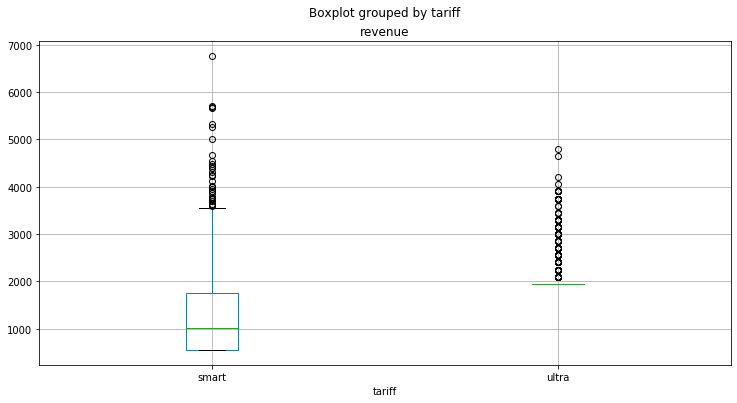

In [61]:
df.boxplot('revenue', by='tariff', figsize=(12,6));

По данному боксплоту видно, что:
- Абоненты тарифа Ультра, платят только абонентскую плату, и совсем небольшое количество выбросов, это люди, которым не хватило базовых лимитов.
- Абонентам тарифа Смарт, явно не хватает базовых лимитов, многие пользователи доплачивают.

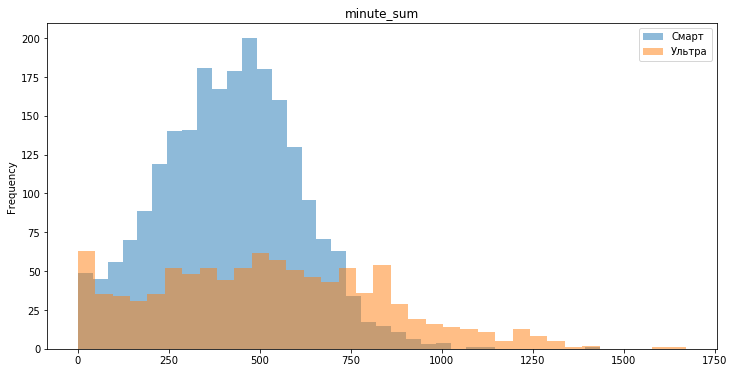

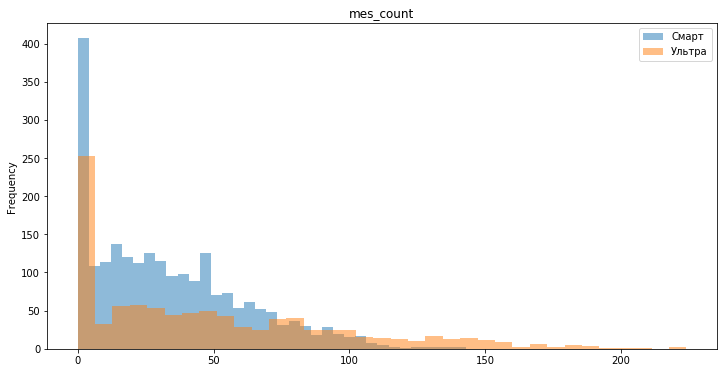

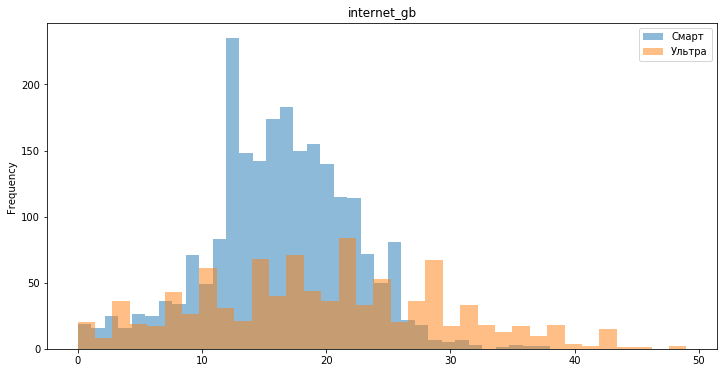

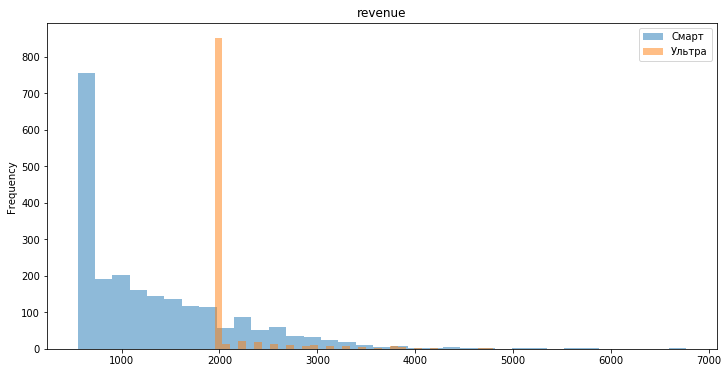

In [62]:
list_of_columns=['minute_sum','mes_count','internet_gb','revenue']

for column in list_of_columns:
    
    df.groupby('tariff')[column].plot.hist(alpha=0.5, legend=True, bins=35, figsize=(12,6))

    plt.legend(['Смарт', 'Ультра'])
    plt.title(column)
    plt.show()

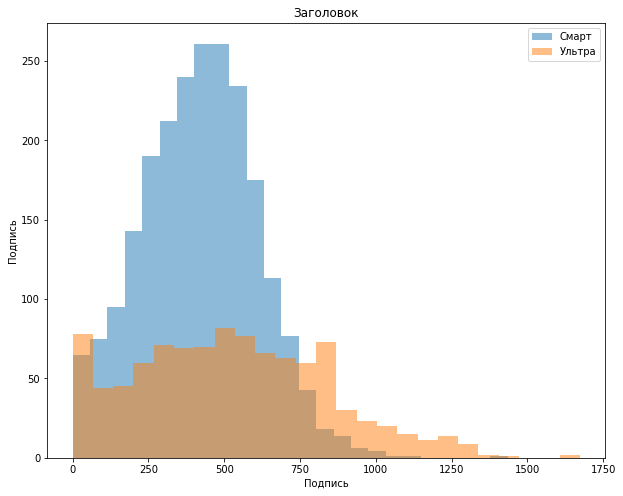

In [63]:
# КОД РЕВЬЮЕРА

df.groupby('tariff')['minute_sum'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Смарт', 'Ультра'])
plt.title('Заголовок')
plt.xlabel('Подпись')
plt.ylabel('Подпись')

plt.show()

## Вывод 
- Все гистограммы абонентов Ультра скошены впрво
- Распределения использованных минут и ГБ похожи на нормальные распределения.
- Абоненты Ультра используют больше смс, минут и Гб, чем абоненты Смарт
- Многие Абоненты Смарта платят за доп услуги, в отличи от Ультры, которые платят только за базовый тариф


# Проверка гипотез

Для проверки гипотез будем использовать ttest

Зададим пороговое значение альфа =0.05

Параметр equal_var = False, т.к. размер выборок разный и дисперсия генеральных выборок неизвесна.

- Нулевая гипотеза H0: средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая
- H1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [64]:
alpha = 0.05

In [65]:
results = st.ttest_ind(
    df.query('tariff== "ultra"')['revenue'], 
    df.query('tariff== "smart"')['revenue'],
    equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


In [66]:
 df.query('tariff== "ultra"')['revenue'].mean()

2070.1522842639592

In [67]:
 df.query('tariff== "smart"')['revenue'].mean()

1289.9735307312696

Средняя выручка по разным тарифам различается.

- Нулевая гипотеза H0: средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов
- H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


In [68]:
results = st.ttest_ind(
    df.query('city== "Москва"')['revenue'], 
    df.query('city != "Москва"')['revenue'],
    equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


In [69]:
 df.query('city== "Москва"')['revenue'].mean()

1546.7135842880523

In [70]:
 df.query('city!= "Москва"')['revenue'].mean()

1524.9362274298885

Средняя выручка по Москве и по регионам, не отличается.

# Общий вывод

Абоненты тарифа Ультра укладываются в свои базовые лимиты и редко покупают допы.
Абоненты Смарта не укладываются в лимиты и часто покупают допы.
Для оператора связи выгоднее продвигать тариф Ультра. Средняя выручка пользователей из Москвы не отличается от пользователей в регионах.